# SPATIAL INTERPOLATION

This Jupyter Notebook can be used to play around with the interpolation script that we will experiment on the streamed data in the previous step. We will perform two kinds of streaming implementation

**- Event Detection:** In this example we will check the average of PM levels over 3 days for each location. If this average exceeds a value of 15, we will then trigger an event/notification for the user. This threshold is defined in the next cell and can be changed

**- Spatial Interpolation:** For this section, we will interpolate the PM 2.5 levels to the extent of Germany's shapefile/area for any specific day using simple linear interpolation method

In [1]:
pm_threshold = 12

In [2]:
## Import Libraries

import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd
import json
import numpy as np
from functools import partial
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata
import geojson
import pandas as pd
import json
import sys
import time
import socket
from confluent_kafka import Consumer, KafkaError, KafkaException, Producer

## KAFKA CONSUMER DEFINITION

In [3]:
### START: AVOID MAKING CHANGES ###

'''
Offset decides in what order to consume the message. "smallest" means read the first message that was sent at 1st position and then the others.
"largest" will mean to read the most 'recent' message in 1st position and then others in the same order
'''

conf = {'bootstrap.servers': 'kafka:9093',
        'default.topic.config': {'auto.offset.reset': 'smallest'},
        'group.id': socket.gethostname()}

### END: AVOID MAKING CHANGES ###

In [4]:
## Set topic name as set in sendStream.py
topic = "pm25_stream"

## Kafka streamed data will be stored here
df = pd.DataFrame(columns=['lat','lon','value','day'])

Initialise the consumer and subscribe to the topic

In [5]:
consumer = Consumer(conf)
consumer.subscribe([topic])

running = True

Define functions that will be used for real-time processing

In [6]:
def event_notification(df, pm_threshold):
    
    '''
    Function to handle event notifications in real-time.
    Checks if the rolling average of PM Levels for 3 days exceeds a certain threshold
    '''
    
    try:
                
        ## Get rolling average of pm value by lat/lon over last 3 days
        rolling_average = df.groupby(['lat','lon']).rolling(3)['value'].mean().reset_index()
        rolling_average.dropna(inplace=True)

        ## Get maximum value and compare it with threshold
        rolling_average_index = rolling_average.nlargest(1, 'value').index[0]

        pm_value = rolling_average.loc[rolling_average_index, 'value']

        ## Trigger check
        if pm_value > pm_threshold:
            location = (rolling_average.loc[rolling_average_index, 'lat'], rolling_average.loc[rolling_average_index, 'lon'])

            ## Trigger notification
            response = event_response(location, round(pm_value,2))
            print(response)
            
        else:
            print("Message Received", msg, " PM 2.5 Levels are safe")

    except:
        pass

def event_response(location, pm):
    return "!!! WARNING !!! The PM 2.5 levels for the location ",location," have exceeded the threshold at the average value of ",pm," over last 3 days"

    '''
    You can insert an email trigger script after this comment
    '''

Trigger the Kafka Consumer, the infinite loop will automatically break if no message is received for more than **10 seconds**

In [7]:
try:
    while running:

        msg = consumer.poll(timeout=10) # wait 10 seconds before exit. If no messages are received for 10 seconds, consuming will stop 
        
        if msg is None:
            break

        if msg.error():
            if msg.error().code() == KafkaError._PARTITION_EOF:
                # End of partition event
                sys.stderr.write('%% %s [%d] reached end at offset %d\n' %
                                    (msg.topic(), msg.partition(), msg.offset()))
            elif msg.error().code() == KafkaError.UNKNOWN_TOPIC_OR_PART:
                sys.stderr.write('Topic unknown, creating %s topic\n' %
                                    (topic))
            elif msg.error():
                raise KafkaException(msg.error())
        else:
                        
            input = json.loads(msg.value())
            key = list(input.keys())[0]
            
            stream = {
                'lat': input[key][0],
                'lon': input[key][1],
                'day': input[key][2],
                'value':  float(key)
            }

            df = df.append(stream, ignore_index = True)
            
            ### EVENT NOTIFICATION SECTION: START ###
            
            event_notification(df, pm_threshold)
            
            ### EVENT NOTIFICATION SECTION: END ###
            
        ## Commit enables processing of a message only once, meaning drops any duplicates, however, you may lose messages that
        ## were not sent for some failure and will not be re-tried. Removing this command is possible but will require further
        ## changes to this script to perform manual de-duplication
        consumer.commit()

except KeyboardInterrupt:
    pass

finally:
    consumer.close()
    
    ## Note: Re-running this cell will note pull the data again as it is already pulled and the consumer is closed. You should
    ## re-run the 'sendStream.py' file to send the data again and then restart this notebook

Message Received <cimpl.Message object at 0x7f186b18f8c0>  PM 2.5 Levels are safe
Message Received <cimpl.Message object at 0x7f186806c140>  PM 2.5 Levels are safe
Message Received <cimpl.Message object at 0x7f186b18fac0>  PM 2.5 Levels are safe
Message Received <cimpl.Message object at 0x7f186b18f8c0>  PM 2.5 Levels are safe
Message Received <cimpl.Message object at 0x7f186b18fac0>  PM 2.5 Levels are safe
('!!! WARNING !!! The PM 2.5 levels for the location ', (48.161591, 11.511011), ' have exceeded the threshold at the average value of ', 12.77, ' over last 3 days')
('!!! WARNING !!! The PM 2.5 levels for the location ', (48.161591, 11.511011), ' have exceeded the threshold at the average value of ', 12.77, ' over last 3 days')
('!!! WARNING !!! The PM 2.5 levels for the location ', (48.161591, 11.511011), ' have exceeded the threshold at the average value of ', 12.77, ' over last 3 days')
('!!! WARNING !!! The PM 2.5 levels for the location ', (50.905215, 6.951178), ' have exceeded 

In [8]:
## Read the output of the streamed file
df.head()

,lat,lon,value,day
0,54.750856,9.125586,9.292316,1
1,53.473352,9.893103,3.009359,1
2,52.441617,13.417584,9.346951,1
3,50.958730,11.613320,17.369565,1
4,49.428931,11.068372,7.866291,1


In the above dataframe, we have data for three different days for each of the 10 locations

In [9]:
## Check how many values are present for each day
df['day'].value_counts()

1    10
2    10
3    10
Name: day, dtype: int64

In [10]:
## To perform spatial interpolation, we will use data from any specific day
df = df[df['day'] == '2']

In [11]:
# Convert Pandas to GeoPandas
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.set_crs(epsg=4326, inplace=True)
gdf.to_crs(epsg=3035, inplace=True)
gdf.drop(['lon','lat'], axis=1, inplace=True)
gdf.head()

,value,day,geometry
10,8.0,2,POINT (4264678.872 3516455.342)
11,14.0,2,POINT (4313901.187 3373954.933)
12,19.0,2,POINT (4553301.110 3264594.485)
13,13.0,2,POINT (4434343.599 3095401.291)
14,19.0,2,POINT (4398513.797 2924567.229)


Plot The Values

<AxesSubplot:>

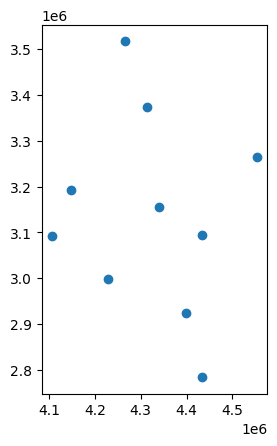

In [12]:
gdf.plot()

The library that we use for interpolation does not directly allow interpolation to a Polygon or is a rather complicated approach. To coutner this, a shapefile "area.geojson" is provided that provides a simpler rectangular extent around Germany.

We first interpolate to this rectangular extent, finally we will crop the boundary of Germany and get a more realistic output

In [13]:
## Read the rectangular extent

with open('../data/area.geojson') as f:
    gj = geojson.load(f)
    
geometry = gj['features'][0]['geometry']
geometry

{"coordinates": [[[2.525436, 56.282503], [16.28127, 56.321305], [15.299506, 46.739752], [4.111352, 46.746634], [2.525436, 56.282503]]], "type": "Polygon"}

<AxesSubplot:>

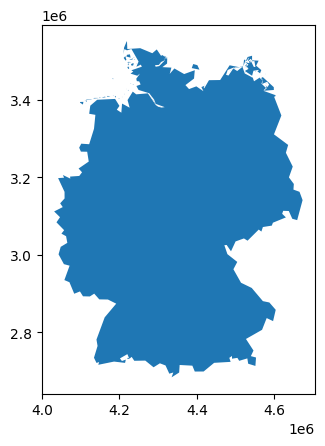

In [14]:
## Plot Germany
germany = gpd.read_file('../data/germany_simplified.shp')
germany.to_crs(epsg=3035, inplace=True)
germany.plot()

<AxesSubplot:>

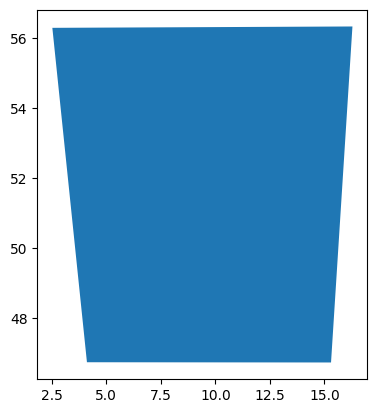

In [15]:
## Plot Rectangular Extent
gpd.read_file('../data/area.geojson').plot()

## Interpolation

In this course, we will use Geocube to generate an interpolated surface.
Note: You can use more sophisticated Libraries as well like "PyKrige"

In [16]:
geo_grid_cubic = make_geocube(
    gdf,
    measurements=["value"],
    rasterize_function=partial(rasterize_points_griddata, method="linear", all_touched=True),
    interpolate_na_method="nearest",
    geom=geometry,
    resolution = (-1500,1500) ## Lowering this number will take longer processing time and more memory
)

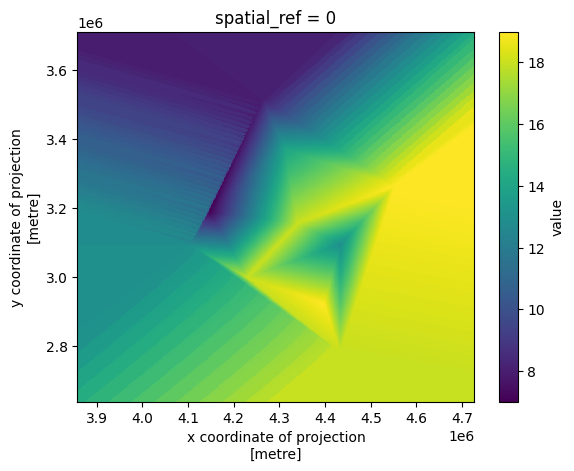

In [17]:
## Plot the Interpolation
geo_grid_cubic.value.plot.imshow()

In [18]:
## Convert xarray (Geocube) output to a DataFrame

output = geo_grid_cubic.to_dataframe().reset_index()
output.head()

,y,x,spatial_ref,value
0,3710250.0,3858750.0,0,7.994877
1,3710250.0,3860250.0,0,7.994877
2,3710250.0,3861750.0,0,7.994877
3,3710250.0,3863250.0,0,7.994877
4,3710250.0,3864750.0,0,7.994877


In [19]:
## Convert this DataFrame to Geopandas

gdf_interpolated = gpd.GeoDataFrame(output, geometry=gpd.points_from_xy(output.x, output.y)).set_crs(epsg=3035)
gdf_interpolated['geometry'] = gdf_interpolated.geometry.buffer(0.0001)
gdf_interpolated.head()

,y,x,spatial_ref,value,geometry
0,3710250.0,3858750.0,0,7.994877,"POLYGON ((3858750.000 3710250.000, 3858750.000..."
1,3710250.0,3860250.0,0,7.994877,"POLYGON ((3860250.000 3710250.000, 3860250.000..."
2,3710250.0,3861750.0,0,7.994877,"POLYGON ((3861750.000 3710250.000, 3861750.000..."
3,3710250.0,3863250.0,0,7.994877,"POLYGON ((3863250.000 3710250.000, 3863250.000..."
4,3710250.0,3864750.0,0,7.994877,"POLYGON ((3864750.000 3710250.000, 3864750.000..."


In [20]:
gdf_interpolated.shape

(413985, 5)

Now we will perform a spatial join, only the region that intersects with the German shapefile will be retained

In [21]:
cropped = germany.sjoin(gdf_interpolated, how="left")[['geometry','value']]
cropped.shape

(158449, 2)

Save Results

In [22]:
# cropped.plot('value', cmap='OrRd') 
## To plot the results, it is recommended to reduce the resolution further down 
## as it uses a lot of memory and might crash your notebook

In [23]:
## Export results to a shapefile (More Time Consuming)
# cropped.to_file('data/interpolated_cropped.shp', driver='ESRI Shapefile')

In [24]:
## Export the rectangular interpolation as raster, quicker to process
geo_grid_cubic.rio.to_raster("../data/interpolated_rectangular.tif")

You can use GIS processing tools like QGIS/ArcGIS Pro to crop the `interpolated_rectangular.tif` using `germany_simplified.shp`
A pre-generated output is already available in `data/interpolated_cropped.tif`

#### END
